# Barometric (Atmospheric) pressure data

## Import libraries

In [1]:
"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

/home/kota/anaconda3/envs/bayes/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4


## Load data

現地気圧は、その場所で観測した気圧の ことで、海面気圧は、現地で観測した気圧を海面上（標高0 メートル）に校正した気圧のことです ([Ref.](https://www.data.jma.go.jp/matsuyama/publication/tenko/tenko202401.pdf))

- 平均現地気圧(hPa)
- 最低海面気圧(hPa)
- ~~最低海面気圧(hPa)現象なし情報~~
- ~~最低海面気圧(hPa)時分~~
- ~~最低海面気圧(hPa)時分現象なし情報~~
- 平均海面気圧(hPa)

In [2]:
file_name = "../../data/weather/pressure.csv"
df = pl.read_csv(file_name, encoding="shift-jis", skip_rows=3)
display(df.columns)
df.columns = ["date", "day_of_week", "mean_pressure", "min_pressure_sea", "min_pressure_sea_info", \
                "min_pressure_sea_time", "min_pressure_time_info", "mean_pressure_sea"]
df = df.with_columns(pl.col("date").str.strptime(pl.Date, "%Y/%m/%d")) # convert day column data type into date type
df = df.with_columns(pl.col("min_pressure_sea_time").str.strptime(pl.Datetime, "%Y/%m/%d %H:%M")) # convert time column data type into datetime
df.head()

['年月日',
 '曜日',
 '平均現地気圧(hPa)',
 '最低海面気圧(hPa)',
 '最低海面気圧(hPa)現象なし情報',
 '最低海面気圧(hPa)時分',
 '最低海面気圧(hPa)時分現象なし情報',
 '平均海面気圧(hPa)']

date,day_of_week,mean_pressure,min_pressure_sea,min_pressure_sea_info,min_pressure_sea_time,min_pressure_time_info,mean_pressure_sea
date,str,f64,f64,i64,datetime[μs],i64,f64
2017-07-01,"""土""",983.8,1007.1,0,2017-07-01 16:51:00,0,1008.1
2017-07-02,"""日""",985.0,1007.5,0,2017-07-02 01:24:00,0,1009.3
2017-07-03,"""月""",982.8,1004.0,0,2017-07-03 17:57:00,0,1006.9
2017-07-04,"""火""",982.3,1004.7,0,2017-07-05 00:00:00,0,1006.6
2017-07-05,"""水""",983.7,1004.0,0,2017-07-05 02:25:00,0,1007.9


## Check nulls

In [3]:
display(df.null_count())

nulls = df.hstack(df.transpose().select(pl.all().is_null().sum()).transpose().rename({"column_0": "null_count"}))
nulls.filter(pl.col("null_count") != 0)

date,day_of_week,mean_pressure,min_pressure_sea,min_pressure_sea_info,min_pressure_sea_time,min_pressure_time_info,mean_pressure_sea
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


date,day_of_week,mean_pressure,min_pressure_sea,min_pressure_sea_info,min_pressure_sea_time,min_pressure_time_info,mean_pressure_sea,null_count
date,str,f64,f64,i64,datetime[μs],i64,f64,u32


現地気圧と海面気圧は同じ間隔で変化するからいらない？

## Visualization

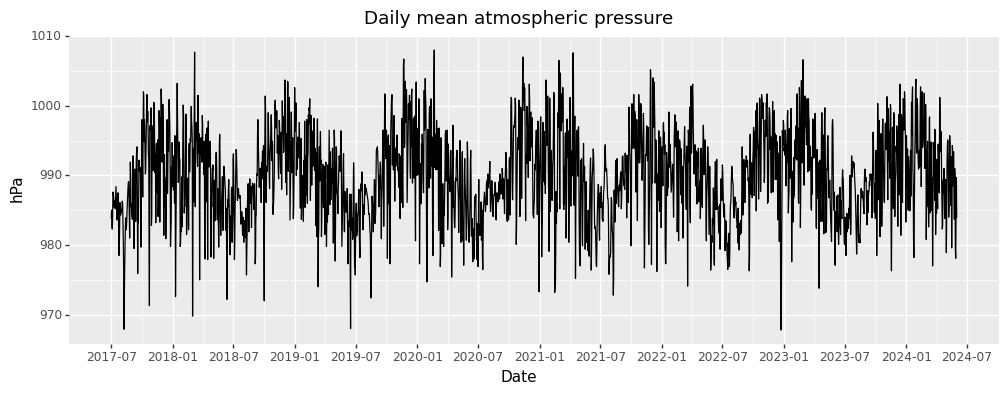

<ggplot: (8747835214035)>

In [4]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_pressure"))
    + labs(title="Daily mean atmospheric pressure", x="Date", y="hPa")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

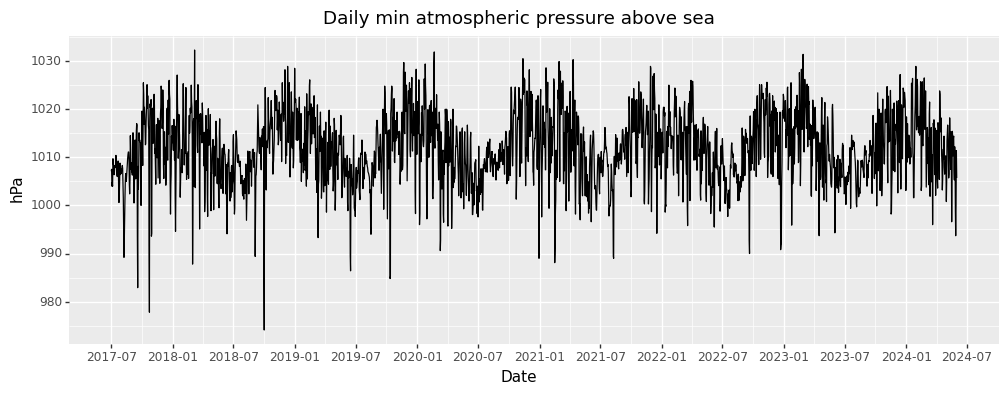

<ggplot: (8747834103496)>

In [5]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="min_pressure_sea"))
    + labs(title="Daily min atmospheric pressure above sea", x="Date", y="hPa")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

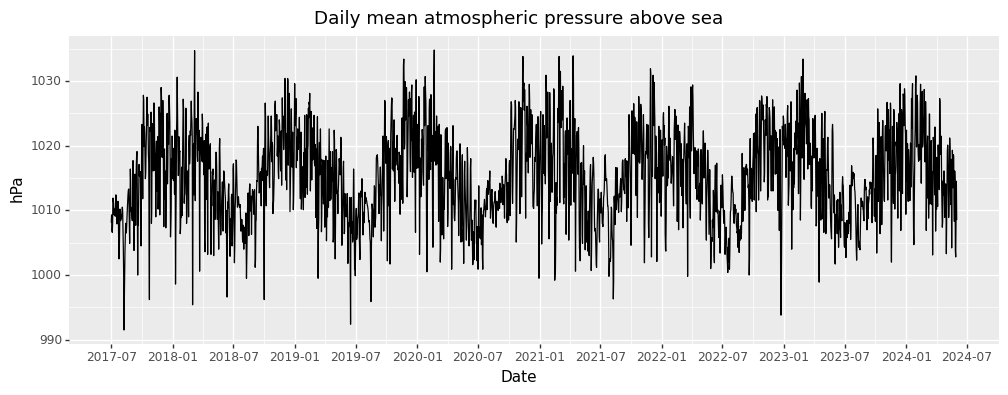

<ggplot: (8747835227944)>

In [6]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_pressure_sea"))
    + labs(title="Daily mean atmospheric pressure above sea", x="Date", y="hPa")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

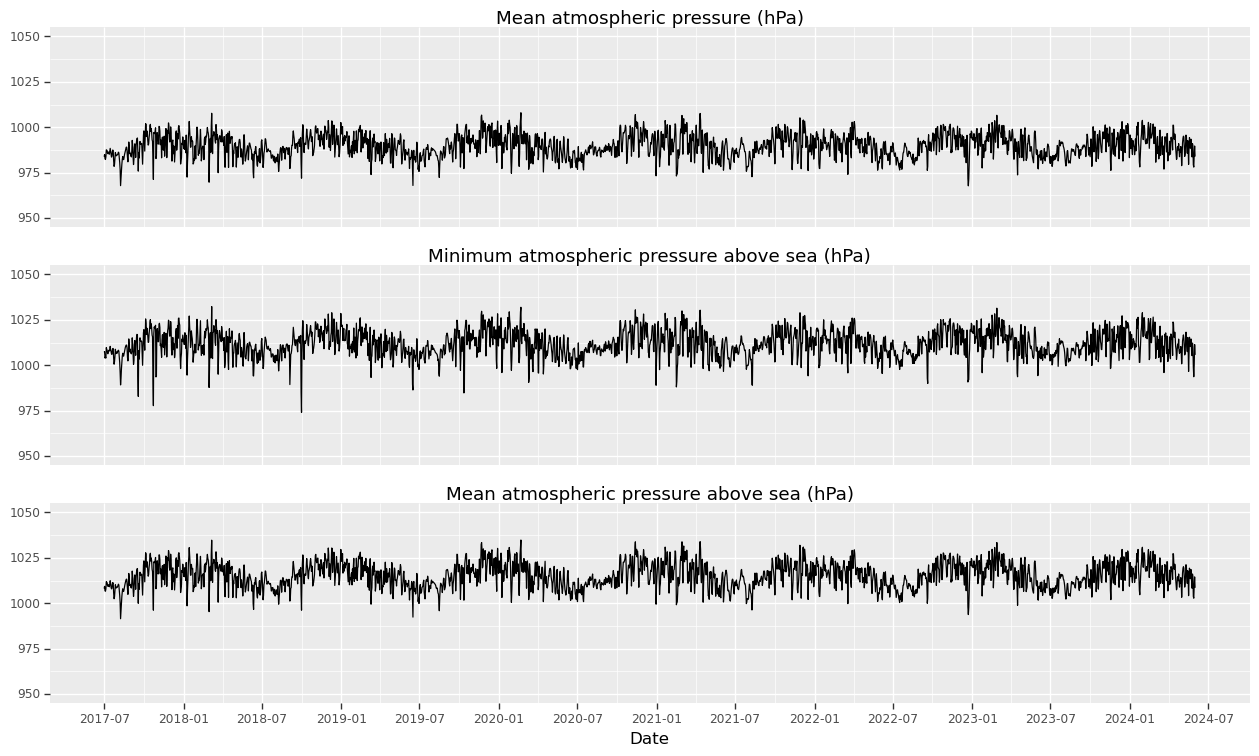

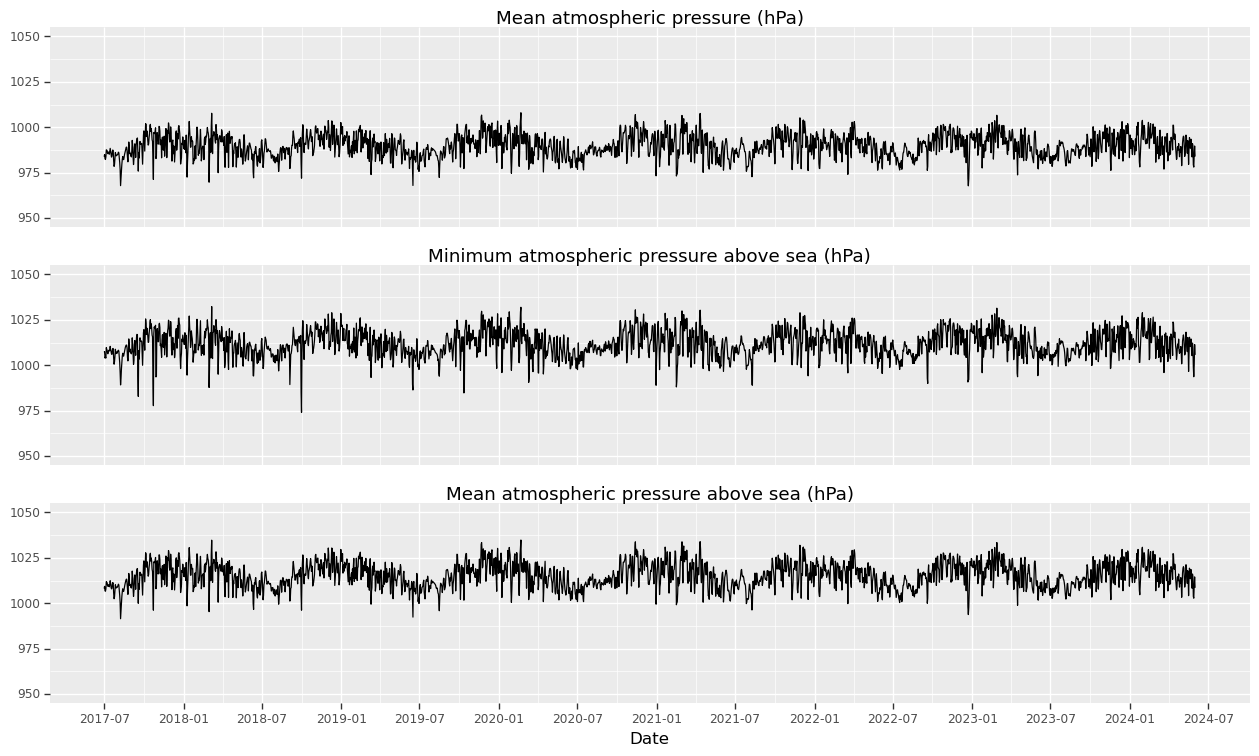

In [7]:
# https://github.com/has2k1/plotnine/issues/46
import patchworklib as pw


g1 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_pressure"))
    + labs(title="Mean atmospheric pressure (hPa)", x="Date", y="")
    + theme(figure_size=(12, 2), axis_title_x=element_blank(), axis_ticks_major_x=element_blank()
            , axis_ticks_minor_x=element_blank(), axis_text_x=element_blank())
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(950, 1050)
)

g2 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="min_pressure_sea"))
    + labs(title="Minimum atmospheric pressure above sea (hPa)", x="Date", y="")
    + theme(figure_size=(12, 2), axis_title_x=element_blank(), axis_ticks_major_x=element_blank()
            , axis_ticks_minor_x=element_blank(), axis_text_x=element_blank())
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(950, 1050)
)

g3 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_pressure_sea"))
    + labs(title="Mean atmospheric pressure above sea (hPa)", x="Date", y="")
    + theme(figure_size=(12, 2))
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(950, 1050)
)

# By specifying g3 in (g3|g2), g1 is positioned exactly on g3.
pw.param["margin"] = 0.2
(
    g1 / g2 / g3
).savefig(fname="../../fig/weather/pressure.png", dpi=500)
